*I have recently stumbled across a reddit link*

> https://redd.it/4dlioz

*to a (now 3-year-old) blog post about a method to arguably enhance AB testing:*

> http://stevehanov.ca/blog/index.php?id=132

The large amount of upvotes this post gathered (now 235) really surprised me, given the tone, the vagueness of the many (unsupported) claims and the blatant errors. Beyond the "someone is wrong on the internet", I thought this would serve as a very good opportunity to exercise our critical mind a bit, challenge these unfounded claims and get a deeper understanding of what we are doing.

Especially, I want to know **how** this proposed method is "better", if it really is, obviously.

What are we talking about?
--------------------------

### Notations

People (among other things), tend to react in a predictable way "on average" to a given stimulus (a.k.a. **event**): e.g. most people tend to switch on the light on the *event* of entering a dark room.

Given a particular *event*, one can *measure* a particular **outcome**. For instance, on the *event* "going out on a rainy day", one can measure/count the particular *outcome* "number of persons carrying an umbrella". Similarly, one could measure the same *outcome* on a sunny day.

However, absolute numbers like "number of persons carrying an umbrella" are not that interesting: imagine there is so much rain that only $3$ persons dared to go outside, all of them carrying an umbrella. The outcome is $3$. Now imagine a sunny day with $10000$ individuals going everywhere with $10$ of them carrying an umbrella. Should we conclude that more people tend to carry umbrellas on sunny days? Obviously not: what we are really interested in is the **probability** of the particular outcome given the initial event. These probabilities become $100$% on a rainy day and $0.1$% on a sunny day.

These *events*, *outcomes* and probability would be long to describe using full sentences each time. That's why from now on, we shall call the events using symbols (in maths parlance) a.k.a. variables (in programming parlance):

- $A$: the *event* "going out on a rainy day";
- $B$: the *event* "going out on a sunny day";
- $O$: the *outcome* "number of people carrying an umbrella";
- $O|A$: the *outcome* "number of people carrying an umbrella" **given** that we are "going out on a rainy day":
- $O|B$: the *outcome* "number of people carrying an umbrella" **given** that we are "going out on a sunny day":

And similarily:

- $P(A)$: the probability of enduring the event A (i.e. "going out on a rainy day");
- $P(B)$: the probability of enduring the event B (i.e. "going out on a sunny day");
- $P(O)$: the probability of people carrying an umbrella (in general);
- $P(O|A)$: the probability of people carrying an umbrella on a rainy day;
- $P(O|B)$: the probability of people carrying an umbrella on a sunny day;

### Blog post case study

Instead of the weather, the blogger decided to study the effect of the "Buy Now!" button color on the click rate of that button. He chose buttons of 3 colors: 

- orange, 
- green and 
- white. 

The user are submitted to three possible events:

- Getting the version of the website with the orange button (which we shall call event $A$);
- Getting that same website with a green button instead (event $B$);
- Same thing with a white button instead (event $C$).

The outcome $O$ that he wants to measure is the "number of clicks on that button".

One can define the corresponding probabilities:

- $P(A)$: the probability of (some user) getting (the website with) the *orange* button;
- $P(B)$: the probability of getting the *green* button;
- $P(C)$: the probability of getting the *white* button;
- $P(O)$: the probability of some user clicking on the button;
- $P(O|A)$: the probability of (some user) clicking on the button given it is *orange*;
- $P(O|B)$: the probability of clicking on the button given it is *green*;
- $P(O|C)$: the probability of clicking on the button given it is *white*;

What the blogger wants is to identify why color he should use to get the maximal probability of people clicking.


### A/B testing

[A/B testing](https://en.wikipedia.org/wiki/A/B_testing) is a method used to answer two different questions:

- *Are $P(O|A)$, $P(O|B)$, etc. significantly different?*
- *If so, what is this difference?*

To do that, you have to ensure that each event occurrence is equiprobable: in our case, that around as many users get an orange, a green or a white button at any given time, in other words, that $P(A) = P(B) = P(C)$.

That said, is it possible to have a $C$ event in A/B testing? Contrary to what was stated in the blog post, yes, definitely. Nothing prevents you from doing that. It is called A/B because you always ever perform two-way comparisons, just like $1 < 10$. Nothing prevents you from adding $5$ in the mix so that $1 < 5 < 10$, in which case you actually perform 2 2-way comparisons as easily.

Whether the difference between $P(O|A)$, $P(O|B)$ and $P(O|C)$ is significant or not is assessed by a statistical test to take fluctuations into account (in that case, it could be [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test)).

Finally, if the differences were proven significant (i.e. that one color gives higher click rates), one can permanently set the button to that color and profit.


### Multi-armed-bandit-based method

One of the drawbacks of the A/B testing method is that even if one event yields a far better outcome than the others, you have to wait for you testing campaign to stop before harvesting these benefits. The method proposed by the blogger consists in favoring the most promising event, that is the one yielding the best outcome as far as we know at any given time. How does he do this? Let's say $P(O|A)$ is bigger than the two others, then we choose $P(A)$ such as $P(A) > P(B) = P(C)$ (the user is more likely to get the version with the orange button rather than the others).

This **inequality is actually the only difference** between his method and typical A/B testing: event $A$ is supposed to give better results, so we have it occurring more often. How would this result be "better"? Well in our case, one could suppose that the more people click on a "Buy Now!" button, the more money we make. This is why we want to maximize our click rate as soon as possible. 

Does it work? Well, it depends and we shall see why.

Numerical modelling and simulation
----------------------------------

Statistics can be tricky. Some results are either too hard to infer analytically, other are just too hard for non-scientists to really grasp and trust. That's why we chose to resort on simulations.

### Building the models

The idea is to define two functions, one to represent how the website behaves (providing different versions of the same website) and one to represent how the user truly behaves...

The web server should provide websites which differ only by the color of a button. As we control the server, we can decide the individual probability of sending any of these colors: $P(X)$ with $X$ which is either $A$, $B$ or $C$.

    >>> import numpy as np
    >>> events = {"A": "got an orange button", "B": "got a green button", "C": "got a white button"}
    >>> P_X = {"A": 1/3, "B": 1/3, "C": 1/3}
    >>> def fetch_website_and_return_event(P_X):
    >>>     event_list = [c for c in events]
    >>>     probability_of_event = [P_X[event] for event in event_list]
    >>>     return np.random.choice(event_list, p=probability_of_event)

    >>> for user_number in range(100): # 100 users visit the website
    >>>     event = fetch_website_and_return_event(P_X)
    >>>     print("The user #%2d endured event %s: she %s"%(user_number, event, events[event]))
    
    The user # 0 endured event A: she got an orange button
    The user # 1 endured event B: she got a green button
    [...]
    The user #98 endured event C: she got a white button
    The user #99 endured event A: she got an orange button


In a similar way, we can represent the behavior of the users by setting $P(O|X)$ (with $X$ which is either $A$, $B$ or $C$) and "drawing" individual outcomes from it. Said more simply, for the sake of the simulation, we assume we know the probability that a user click on the button given its color and we want to create a function that does just that for each individual users:

    >>> P_O_X = {"A": 0.001, "B": 0.01, "C": 0.5}
    >>> def has_user_clicked_on_the_button(event, P_O_X):
    >>>     return np.random.uniform(low=0.0, high=1.0, size=None) < P_O_X[event]

    >>> for user_number in range(100):
    >>>     event = fetch_website_and_return_event(P_X)
    >>>     if has_user_clicked_on_the_button(event, P_O_X):
    >>>         has_clicked = "and clicked on it!"
    >>>     else:
    >>>         has_clicked = "and DIDN'T click on it!"
    >>>     print("The user #%2d %s"%(user_number, events[event]), has_clicked)

    The user # 0 got a white button and clicked on it!
    The user # 1 got a white button and DIDN'T click on it!
    [...]
    The user #98 got a white button and DIDN'T click on it!
    The user #99 got an orange button and DIDN'T click on it!
    
And here we are: we are almost ready to simulate our campaigns ! :)

### Campaigns

As we said, in A/B testing, $P(A) = P(B) = P(C)$, therefore the code we already shown is already suited to this use case: all we have to do is to gather results so that they can be analyzed. We will do that in a `pandas` dataframe.

In the case of the multi-armed bandit, $P(O|X)$ (`P_O_X`) should be updated at each iteration to favor the event which yields the best outcome yet.

However, our models as implemented until now are particularly slow in Python (explicit loops, etc.). This is why the versions we will actually be using will be different, a bit less readable, but more efficient and *equivalent* (do the same thing).

In [1]:
def AB_campaign(number_of_users, P_O_X):
    event_per_user = np.random.choice([event for event in P_O_X], size=number_of_users)
    click_proba_per_user = np.empty_like(event_per_user, dtype=np.float64)
    for event, proba in P_O_X.items():
        click_proba_per_user[event_per_user == event] = proba
    click_per_user = np.random.uniform(low=0.0, high=1.0, size=number_of_users) < click_proba_per_user
    return click_per_user, event_per_user

On my computer, this version is close to $500\times$ faster than a "naive" version using the functions defined above:

    >>> %timeit AB_campaign(100000, P_O_X)
    100 loops, best of 3: 17.3 ms per loop
    >>> %timeit naive_AB_campaign(100000, P_O_X)
    1 loop, best of 3: 8.51 s per loop
    
Now let's define the multi-armed bandit version... Again one could use the functions defined above and could follow perfectly the pseudo-code given in the blog post.

Here, one can first figure out that his algorithm can be reformulated: let's say that event $A$ is favored $90$% of the time *as defined in the blog post*, that is $A$ will occur $90$% of the time (dubbed "exploitation" in the blog post). What happens the remaining $10$% of the time (dubbed "exploration" in the pseudocode)? Any event can occur with equal probability: $A$, $B$ or $C$. The problem can therefore be reformulated this way: if $A$ is favored, it should occur $90 + \frac{10}{3}$% of the time, $B$ should occur $\frac{10}{3}$% of the time and $C$ should occur $\frac{10}{3}$% of the time.

We can generalize this to any amount, $f \in [0; 1]$:
$$P(\text{favored event}) = f + \frac{1-f}{\text{number of events}}$$
and
$$P(\text{disfavored event}) = \frac{1-f}{\text{number of events}}$$

In [2]:
def MultiArmedBandit_campaign(number_of_users, P_O_X, f=0.9):
    l = len(P_O_X)
    disfav = (1-f)/l
    fav = f + disfav
    # Let's put everything in lists and use indices instead of dict/event name
    indices = np.array(list(range(l)))
    event_list = np.array([event for event in P_O_X]) # provide an order
    P_O_X_list = np.array([P_O_X[event] for event in event_list])
    
    # Let's keep the sum of clicks for each
    clicks_per_X = np.ones_like(event_list, dtype=np.int)
    events_per_X = np.ones_like(event_list, dtype=np.int)
    
    # Generate all the random draws here and now 
    rdm_click = np.random.uniform(low=0.0, high=1.0, size=number_of_users)
    
    # Pregenerate all the lists of random number from the start
    # Bad for memory, good for speed!
    P_X_fav = np.zeros((number_of_users, l), dtype=np.int)
    for i in range(l):
        P_X_list = [disfav] * l
        P_X_list[i] = fav
        P_X_fav[:, i] = np.random.choice(indices, p=P_X_list, size=number_of_users)
    
    # Init all the relevant arrays
    event_idx_per_user = np.zeros(number_of_users, dtype=np.int)
    fav_idx_per_user = np.zeros(number_of_users, dtype=np.int)
    click_per_user = np.zeros(number_of_users, dtype=np.bool)
    
    # Now perform the expensive loop
    for user_number, cmp_click in enumerate(rdm_click):
        # Get event to favor
        fav_idx = np.argmax(clicks_per_X/events_per_X)
        # Get event idx depending on fav:
        # just extract it from the correct column
        # of pregenerated random events
        event_idx = P_X_fav[user_number, fav_idx]
        
        # Update relevant arrays and cumulated sums
        event_idx_per_user[user_number] = event_idx
        fav_idx_per_user[user_number] = fav_idx
        events_per_X[event_idx] += 1
        has_clicked = (cmp_click < P_O_X_list[event_idx])
        clicks_per_X[event_idx] += has_clicked
        click_per_user[user_number] = has_clicked
        
    # Finally convert indices into event names
    event_per_user = np.empty_like(event_idx_per_user, dtype=np.str)
    fav_per_user = np.empty_like(fav_idx_per_user, dtype=np.str)
    for idx, event in enumerate(event_list):
        event_per_user[event_idx_per_user == idx] = event
        fav_per_user[fav_idx_per_user == idx] = event
    return click_per_user, event_per_user, fav_per_user

On my computer, this version is only 10 times slower than the A/B testing one and more than a thousand time faster than the naive approach:

    >>> %timeit MultiArmedBandit_campaign(10000, P_O_X)
    10 loops, best of 3: 133 ms per loop

### Calculating the uncertainty

Now that we have (hopefully) working algorithms, we have to ensure that they behave as intended. Such a demonstration would be tedious. Instead, we will check the probability density function of $\tilde{P}(O|X)$ in a few cases and compare it to the theoretical one. Conversely, this is a great way to introduce that particular theoretical function and to confirm it is the correct one.

That function is the [$Beta$ function](https://en.wikipedia.org/wiki/Beta_distribution#Probability_density_function). Let's define $\alpha$ and $\beta$ such that:

$$\alpha = O|X + 1 \quad \text{and} \quad \beta = X - O|X + 1$$

then the probability density function of $\tilde{P}(O|X)$ is 

$$Beta(\alpha, \beta)$$

In [3]:
# Implement a series of campaigns to estimate the distribution of the estimated P(O|X).
# Many P(O|X) can be given: one dataframe is computed per P(O|X) and appended to the df_list list.
import pandas as pd
def series_of_campaigns(number_of_campaigns, number_of_users, P_O_X_list, campaign_function=AB_campaign):
    event_list = [event for event in P_O_X_list[0]]       # Set the order of the events
    num_event = ["$%s$"%(event) for event in event_list]  # X
    num_click = ["$O|%s$"%(event) for event in event_list]# O_X
    columns = num_event + num_click    # for the dataframe
    df_list = [None] * len(P_O_X_list) # df_list[n] is calculated from 'number_of_campaigns'
                                       # with 'number_of_users' users per campaign for P_O_X_list[n]
    for i, P_O_X in enumerate(P_O_X_list):
        data = np.empty([number_of_campaigns, len(columns)], dtype=np.float)
        for campaign_number in range(number_of_campaigns):
            clicks, events = campaign_function(number_of_users, P_O_X)[:2]
            for j, event in enumerate(event_list):
                mask = (event == events)
                nevents = mask.sum()
                nclicks = clicks[mask].sum()
                data[campaign_number, j] = nevents
                data[campaign_number, j+3] = nclicks
        df_list[i] = pd.DataFrame(data, columns=columns)
    return df_list


from scipy.stats import gaussian_kde, beta

def experimental_error(x, X, O_X):
    # Gaussian kernel density estimation
    # Defaults to using Scott's rule
    # which is optimal if the underlying
    # distribution is roughly Gaussian
    y = gaussian_kde(O_X/X).evaluate(x)
    return y

def theoretical_error(x, X, O_X):
    # use Beta from scipy
    # X: individual events (A, B, C)
    # corresponding to a (orange, green, white) button
    # O_X: number of clicks given X (i.e. given the color)
    k = np.mean(O_X)
    n = np.mean(X)
    a = k + 1
    b = n - k + 1
    y = beta.pdf(x, a, b)
    return y

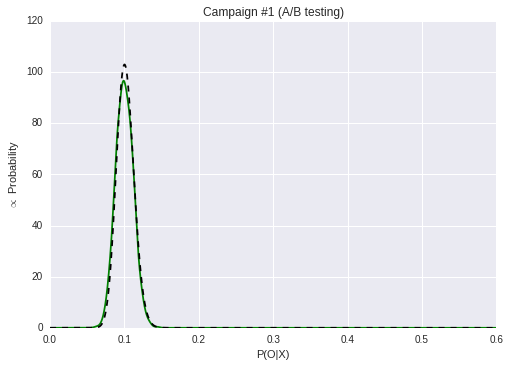

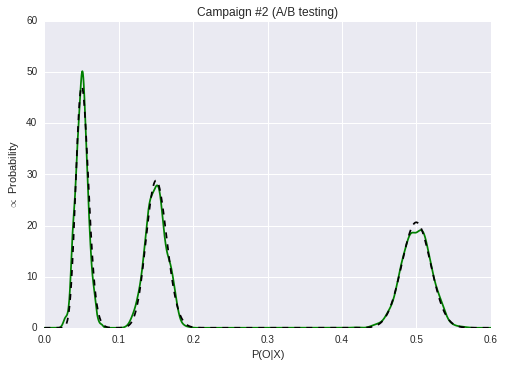

In [4]:
# Actual comparison for the A/B testing method

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt, rcParams
rcParams['figure.figsize'] = (10,8)
import seaborn

POX = [
    {"A": 0.1, "B": 0.1, "C": 0.1},
    {"A": 0.05, "B": 0.15,  "C": 0.5}
]


N, M = 2000, 1000
df_list = series_of_campaigns(M, N, POX, campaign_function=AB_campaign)

x = np.linspace(0., 0.6, 2000)
for i, df in enumerate(df_list):
    plt.figure()
    plt.title("Campaign #%d (A/B testing)"%(i+1))
    plt.xlabel("P(O|X)")
    plt.ylabel("$\propto$ Probability")
    y_exp = np.zeros_like(x)
    y_theo = np.zeros_like(x)
    for event in POX[0]:
        X = df["$%s$"%event]
        O_X = df["$O|%s$"%event]
        y_exp += experimental_error(x, X, O_X)
        y_theo += theoretical_error(x, X, O_X)
    plt.plot(x, y_exp, "g")
    plt.plot(x, y_theo, "k--")

Not bad! :) If you really look into the details, you might notice that the fit is slightly worse for small $P(O|X)$. Two reasons to that: 

1. $P(O|X)$ is, well... small, so we should increase $N$ to get a better fit.
2. The method we used to estimate the probability density function is based on a (symmetric) Gaussian kernel which tends to perform not as well for an underlying asymmetric density: to get better results, we would need to increase $M$. 

And yes, we are looking at a probability of getting a particular $P(O|X)$ value that is already a probability. 

Now let's do the same with the multi-armed-bandit-based method with the default 90/10 split.

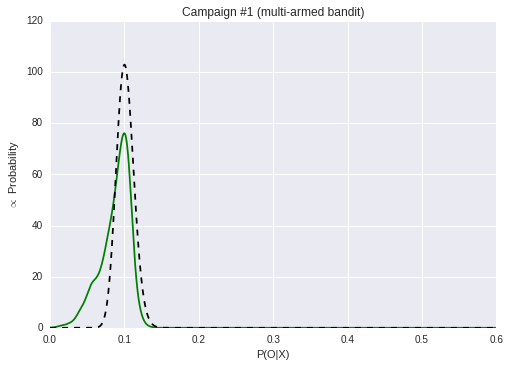

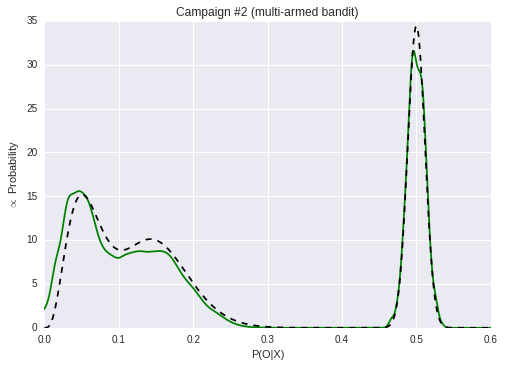

In [5]:
# Actual comparison for the multi-armed-bandit method

N, M = 2000, 1000
df_list = series_of_campaigns(M, N, POX, campaign_function=MultiArmedBandit_campaign)

x = np.linspace(0., 0.6, 2000)
for i, df in enumerate(df_list):
    plt.figure()
    plt.title("Campaign #%d (multi-armed bandit)"%(i+1))
    plt.xlabel("P(O|X)")
    plt.ylabel("$\propto$ Probability")
    y_exp = np.zeros_like(x)
    y_theo = np.zeros_like(x)
    for event in POX[0]:
        X = df["$%s$"%event]
        O_X = df["$O|%s$"%event]
        y_exp += experimental_error(x, X, O_X)
        y_theo += theoretical_error(x, X, O_X)
    plt.plot(x, y_exp, "g")
    plt.plot(x, y_theo, "k--")

What the hell is happening?! Well, a few things:

1. Campaign #2: If you look at $X$ and $O_X$ (code below), you will see that the event associated with lower $P(O|X)$ occurs very rarely, so larger uncertainties were indeed expected. This is by design.
2. Campaign #1 and #2: The tail, which is straying away from the expected distribution, is induced by random instabilities. The algorithm tends to favor one of $A$, $B$ or $C$ due to random fluctuations that are exaggerated by  the algorithm (i.e. "by design").

Also notice (blatant in Campaign #1) that the given distribution is plain **wrong**! It is simply **not** what it should be, it is simply **not** what we **know** it is (because it is us who defined the hidden truth at the beginning, the ideal $P(O|X)$).

In [6]:
# Demonstration of claim #1: X inducing lower P(O|X) occurs less often than it would in A/B testing,
# increasing the uncertainty for these small values.
for i, df in enumerate(df_list):
    print("Campaign #%d:"%(i+1))
    for event in POX[0]:
        X = df["$%s$"%event]
        O_X = df["$O|%s$"%event]
        X_AB = N/len(POX[0])
        O_X_AB = X_AB*POX[i][event]
        print("    - Event %s occurred %4d times and %3d clicks were registered."%(event, X.mean(), O_X.mean()))
        print("                  A/B: %4d times,    %3d clicks"%(X_AB, O_X_AB))

Campaign #1:
    - Event A occurred  686 times and  69 clicks were registered.
                  A/B:  666 times,     66 clicks
    - Event B occurred  652 times and  65 clicks were registered.
                  A/B:  666 times,     66 clicks
    - Event C occurred  660 times and  65 clicks were registered.
                  A/B:  666 times,     66 clicks
Campaign #2:
    - Event A occurred   69 times and   3 clicks were registered.
                  A/B:  666 times,     33 clicks
    - Event B occurred   71 times and  10 clicks were registered.
                  A/B:  666 times,     99 clicks
    - Event C occurred 1858 times and 929 clicks were registered.
                  A/B:  666 times,    333 clicks


In [7]:
# Demonstration of claim #2: the algorithm tends to wrongly artificially introduce large differences
# Let's demontrate that by NOT averaging over "fresh" runs but inside a single run.

print("The expected P(O|X) are IDENTICAL: %s"%POX[0])
print("Therefore each X should occur the around the same number of times.\n")

for i in range(3):
    print("Try #%d"%(i+1))
    clicks, events = MultiArmedBandit_campaign(N, POX[0])[:2]
    for event in POX[0]:
        mask = (events == event)
        nevents = mask.sum()
        nclicks = clicks[mask].sum()
        estimated_P_O_X = nclicks/nevents
        print("    - Event %s"%event, "occured %4d times"%nevents, "and gave P(O|%s) = %5.2f%%"%(event, 100*estimated_P_O_X))

The expected P(O|X) are IDENTICAL: {'A': 0.1, 'B': 0.1, 'C': 0.1}
Therefore each X should occur the around the same number of times.

Try #1
    - Event A occured  265 times and gave P(O|A) =  9.43%
    - Event B occured  184 times and gave P(O|B) =  9.24%
    - Event C occured 1551 times and gave P(O|C) = 10.06%
Try #2
    - Event A occured  111 times and gave P(O|A) =  8.11%
    - Event B occured  267 times and gave P(O|B) =  9.74%
    - Event C occured 1622 times and gave P(O|C) = 10.42%
Try #3
    - Event A occured   79 times and gave P(O|A) =  2.53%
    - Event B occured   83 times and gave P(O|B) =  3.61%
    - Event C occured 1838 times and gave P(O|C) = 10.28%


Well, as you can see, there is **always** a favored event. That favored event is very well defined and it gives values close to the expected $10$%. However the disfavored ones can yield values pretty far away. As an example, I got the following results:

    Try #1
       - Event C occured 1727 times and gave P(O|C) = 10.54%
       - Event A occured  201 times and gave P(O|A) =  7.46%
       - Event B occured   72 times and gave P(O|B) =  4.17%
       
How many trials would be required so that $P(O|A)$ has a $50$% chance of reaching $9.5$% or above from that state assuming $P(O|C)$ stays at $10$% exactly? Around $14000$ more. What about $80$%? You would need around $40000$ more iterations. And $90$%? $80000$ more iterations. Yep, this is an exponential cumulative distribution function: to get $10$% more confidence you need to roughly double the number of trials.

What about A/B testing? In the **very unlikely** situation in which you would get that much asymmetry, it would only require $14000$ more iterations to get a $95$% confidence that $P(O|A) > 9.5$%.

Conclusion
----------

Finished yet?/at last?! yes and no... At first I wanted to study the behavior of the proposed method more deeply. I wanted to see how the number of user affected the results, I wanted to actually apply Fisher's exact test to see whether the errors would cancel out, test different favoring coefficients, and so on.

However this does not seem necessary at this point as the evidence is compelling.

1. The multi-armed-bandit-based method *assumes* that there is a difference. This explains why it works reasonably well when there is a clear difference and why it behaves so badly when there is none (well, as $P(O|X)$ tends toward $0$, it gets better but never as quickly as the A/B method). At this point, you will have a hard time explaining that there is no difference: your boss will see $4.17$% and $10.54$% and no $p$-value will convince him. 
2. That is, if the $p$-value still means something: you can't apply a test made on the assumption that the posterior distribution follows $Beta$ on something behaving differently.
3. Furthermore, the proposed method is very sensitive to variations in the underlying behavior... For instance, I would expect more people to buy stuff at christmas, temporarily changing $P(O)$ itself (and therefore the individual $P(O|X)$). As an exercise, try to change the code to handle changing $P(O|X)$: you will see the A/B testing method recovering quicker.

All of that can be summed up to this: the multi-armed bandit method has been created to maximize the gain/reward, not to determine whether or not there is a difference. While this is of no consequence when choosing the "best" slot machine, this would be fearsome if applied in clinical tests: because one wanted to cure the maximum of persons during the tests, thousands of people died because the drug was actually no better than sugar...

A website is obviously closer to a slot machine than a clinical test. However, the efficiency of the method seems largely overstated: it works well when the difference is large and such differences would be very quickly spotted by a short preliminary A/B test. Smaller differences are much harder to spot with the proposed method than with proper A/B testing. But don't trust me: run the code.

In [8]:
from datetime import datetime, timezone
datetime.utcnow()

datetime.datetime(2016, 4, 9, 1, 44, 54, 505222)